In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import sys
import time
from multiprocessing import Process, Pool
import warnings
warnings.simplefilter('ignore')

# Add module path to system path
module_paths = ['..', 
                '../..',
                '../../extern/PsrPopPy',
                # '/Users/vohl/opt/miniconda3/lib/python3.9/site-packages'
                # '/Users/vohl/miniconda3/lib/python3.10/site-packages'
               ]
for module_path in module_paths:
    if os.path.abspath(os.path.join(module_path)) not in sys.path:
        sys.path.insert(0, module_path)
    
    
# For convenience
import numpy as np
import pickle

import pandas as pd

from epn_mining.main import load_states, save, load
from epn_mining.preparation import epn
from epn_mining.preparation.pulsar import Population, Observation, Pulsar, Model, Component
from epn_mining.topology import topology
from epn_mining.analysis.stats import (
    centroid as compute_centroid,
    profile_as_distribution,
    evaluate_DPGMM,
    convert_x_to_phase
)
from epn_mining.analysis import stats
from epn_mining.analysis.distance import (check_bound, check_min_max, check_neg)

from epn_mining.preparation.signal import (
    shift_max_to_center, 
    shift_centroid_to_center,
    rotate,
    best_alignment
)

from epn_mining.analysis import plotting
from epn_mining.analysis.stats import profile_as_distribution

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import axes_grid1
from matplotlib import rc
from matplotlib import style, collections as mc, colors, cm

style.use('default')

style.use('default')

import json
from sklearn import mixture
from scipy.stats import norm
from joblib import parallel_backend
from tqdm import tqdm

# from dtaidistance import dtw

from dtw import dtw

import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

import copy

# Set session variables
verbose = True
state_store=True

pink = (230/255, 29/255, 95/255, 1)
blue = (47/255, 161/255, 214/255, 0.2)
blue_full = (47/255, 161/255, 214/255, 1)

cmap = cm.get_cmap('cubehelix').reversed()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
state_prefix='paper'
population = load('population', state_prefix=state_prefix)

In [ ]:
pulsar = population.as_array()[0]

In [ ]:
pulsar.observations[2].stokes_I.size//2

In [ ]:
# Gausspy related (to be incorporated to epn_mining later)

import gausspy.gp as gp

from epn_mining.analysis.stats import robust_statistics, median_of_medians, median_of_stdevs, snr
from epn_mining.utils.io import state_full_location, set_state_name

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
    
def unravel(list):
    return np.array([i for array in list for i in array])

def _set(x, y, y_err, data:list={}):
    data['data_list'] = data.get('data_list', []) + [y]
    data['x_values'] = data.get('x_values', []) + [x]
    data['errors'] = data.get('errors', []) + [y_err]
    return data

def set_n_save_data(obs:Observation, data={}, variable='data', state_prefix='', 
                    verbose=False):
    data = _set(
        data = data,
        x = obs.phase, 
        y = obs.stokes_I,
        y_err = np.ones(obs.phase.size) * median_of_stdevs(obs.stokes_I)
    )
    
    save(variable, data, state_prefix=state_prefix, verbose=verbose)

def autonomous_gaussian_decomposition(state_prefix='', 
                                      variable='observation', 
                                      alpha1=1., 
                                      alpha2=None,
                                      snr_thresh=5.,
                                      return_data=True,
                                      train=False,
                                      verbose=False):    
    # init
    g = gp.GaussianDecomposer()

    # AGD parameters
    g.set('phase', 'one' if alpha2 is None else 'two')
    g.set('SNR_thresh', [snr_thresh, snr_thresh])
    g.set('alpha1', alpha1)
    if alpha2 is not None:
        g.set('alpha2', alpha2)

    # decompose
    data_decomp = g.batch_decomposition(
        science_data_path=state_full_location(state_prefix, variable)
    )

    return data_decomp

def components_arrays(obs):
    components = [gaussian(amp, fwhm, mu)(obs.phase) for i, (mu, fwhm, amp) in enumerate(zip(
        unravel(obs.model_agd['means_fit']),
        unravel(obs.model_agd['fwhms_fit']),
        unravel(obs.model_agd['amplitudes_fit']),
    ))]
    
    return components

def model_array(obs):
    for i, component in enumerate(components_arrays(obs)):
        model = component if i==0 else model + component
        
    model = (model - model.min()) / (model.max() - model.min())
        
    return model


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Define simple gaussian
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

pulsar = population.pulsars['J0534+2200'] #'J2145-0750'] #'J1807-0847'] #['J2326+6113']
obs = pulsar.observations[5]

phase_thres = .6
cond = np.where(np.abs(obs.phase) < phase_thres)

# Generate sample from three gaussian distributions
# samples = np.random.normal(-0.5, 0.2, 2000)
# samples = np.append(samples, np.random.normal(-0.1, 0.07, 5000))
# samples = np.append(samples, np.random.normal(0.2, 0.13, 10000))

samples = profile_as_distribution(obs.stokes_I[cond], obs.phase[cond], 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[8, 5], sharex=True)
# Fit GMM

for c in ['bgm', 'gm']:
    if c == 'bgm':
        gmm = BayesianGaussianMixture(n_components=30, 
                                      weight_concentration_prior_type='dirichlet_process',
                                      weight_concentration_prior=1e4,
                                      max_iter=1000,
                                      mean_prior=None, 
                                      mean_precision_prior=None,
                                      covariance_type="full", 
                                      tol=1e-3)
    else:
        gmm = GaussianMixture(n_components=7, 
                              covariance_type="full", 
                              tol=1e-5)

    gmm = gmm.fit(X=samples)

    # Evaluate GMM
    gmm_x = obs.phase
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1, 1)))


    _gmm_x = obs.phase[cond]
    _gmm_y = np.exp(gmm.score_samples(_gmm_x.reshape(-1, 1)))
    _gmm_y = (_gmm_y - _gmm_y.min()) / (_gmm_y.max() - _gmm_y.min())
    _gmm_y = _gmm_y - _gmm_y.min()
    # Construct function manually as sum of gaussians
    # gmm_y_sum = np.full_like(gmm_x, fill_value=0, dtype=np.float32)
    # for m, c, w in zip(gmm.means_.ravel(), gmm.covariances_.ravel(), gmm.weights_.ravel()):
    #     gauss = gauss_function(x=gmm_x, amp=1, x0=m, sigma=np.sqrt(c))
    #     gmm_y_sum += gauss / np.trapz(gauss, gmm_x) * w

    # Make regular histogram
    # ax.hist(samples, bins=50, density=True, alpha=0.5, color="#0070FF")
    if c == 'bgm':
        ax[0].plot(obs.phase[cond], obs.stokes_I[cond], linestyle=':', zorder=1000, alpha=0.5)
    ax[0].plot(_gmm_x, _gmm_y, lw=2, alpha=0.5, label=c)
    ax[1].plot(obs.phase[cond], obs.stokes_I[cond]-_gmm_y, lw=2, alpha=0.5, label=c)
    ax[0].legend()
    # ax.plot(gmm_x, gmm_y_sum, color="black", lw=4, label="Gauss_sum", linestyle="dashed")

    # Annotate diagram
    ax[0].set_ylabel("Probability density")
    ax[1].set_ylabel("Residual")
    ax[1].set_xlabel(f"$\phi$")

# Make legend
plt.legend()

In [ ]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(obs.phase, gmm_y)
ax[0].plot(obs.phase[cond], _gmm_y)

ax[1].plot(obs.phase[cond], gmm_y[cond]-_gmm_y)

In [ ]:
vals = np.array([obs.phase[i] for i, v in enumerate(obs.stokes_I) for ii in range(np.round(v*1000).astype(int))])

In [ ]:
plt.hist(vals, bins=obs.phase);

In [ ]:
i = 0.02

In [ ]:
freqs_to_include = [2, 3, 4, 5]
for pulsar in population.as_array():
    for f in freqs_to_include:
        obs = pulsar.observations[f]
        

In [ ]:
freqs_to_include = [2, 3, 4, 5]

for i, pulsar in enumerate(tqdm(population.as_array())):
    centroids = []
    snrs = np.array([[pulsar.observations[f].snr, f] for f in freqs_to_include])
    freqs_snr_sorted = snrs[np.argsort(snrs, axis=0).T[0]][::-1].T[1]
    first = True
    for freq_id in freqs_snr_sorted:
        pulsar.observations[freq_id].set_model(
            'stokes_I', 
            alpha=10**4,
            threshold=True,
            n_components=30,
            cut=False, 
            scale=True,
            fwhm=None if first else pulsar.observations[freqs_snr_sorted[0]].fwhm,
            override=True
        )
        if first:
            first = False

save('population', population, state_prefix=state_prefix)


In [ ]:
slight_shift = { 
    'J1705-1906': -150, 
    'J1825-0935': -150,
    'J1857+0943': -150,
    'J1932+1059': -150,
    'J1939+2134': -300,
}

# jname = population.fitted_later[2]
jname = list(slight_shift.keys())[-1]
print (jname)

# population.pulsars[jname].observations[f].stokes_I = np.roll(population.pulsars[jname].observations[f].stokes_I, 
#                                                              population.pulsars[jname].observations[f].stokes_I.size//2)

# population.pulsars[jname].observations[f].phase = np.roll(population.pulsars[jname].observations[f].phase, 
#                                                              population.pulsars[jname].observations[f].phase.size//2)

# population.pulsars[jname].observations[f].stokes_I = shift_centroid_to_center(
#     phase=population.pulsars[jname].observations[f].phase, 
#     profile=population.pulsars[jname].observations[f].stokes_I
# )[0]


# population.pulsars[jname].observations[f].set_model(
#     'stokes_I', 
#     alpha=1e4,
#     threshold=True,
#     tol=0.00001,
#     max_iter=4000,
#     n_components=30,
#     cut=False, 
#     scale=True,
#     fit_whole=False,
#     fwhm=None,
#     override=True
# )

# population.pulsars[jname].observations[f].set_model(
#     'stokes_I', 
#     alpha=0.5,
#     threshold=True,
#     tol=0.001,
#     max_iter=4000,
#     n_components=30,
#     cut=False, 
#     scale=True,
#     fit_whole=False,
#     fwhm=None,
#     override=True,
#     has_interpulse=jname in 
# )

# population.pulsars[jname].observations[f].gmm.converged_, population.pulsars[jname].observations[f].gmm.n_iter_

In [4]:
with_interpulse = ['J1705-1906', 'J1825-0935', 'J1836-1008', 'J1857+0943', 'J1932+1059', 'J1939+2134', 'J0534+2200', 'J2145-0750']

# 'J1730-2304'

keep_more_components = ['J0437-4715']



to_be_refitted = ['J2145-0750'] #'J1825-0935'

# with_interpulse = 'J0534+2200'

with_scattering = ['J1836-1008', 'J1730-2304']

# 12013+3845 freq=3 : needs to be convolved?

In [5]:
freqs_to_include = [2, 3, 4, 5]


window=0.1
window_roll=102


# for pulsar in tqdm(population.as_array()):
# pulsar = population.pulsars['J0437-4715'] #['J1730-2304'] #[with_interpulse]
for jname in to_be_refitted:
    pulsar = population.pulsars[jname]
    for f in freqs_to_include:
# f = 3
        population.pulsars[pulsar.jname].observations[f].set_model(
            'stokes_I', 
            alpha=0.5 if not pulsar.jname in keep_more_components else 10**4,
            threshold=True,
            tol=0.001,
            max_iter=4000,
            n_components=30,
            cut=False, 
            scale=True,
            fit_whole=pulsar.jname in with_interpulse,
            window=window, 
            window_roll=window_roll,
            fwhm=None,
            override=True,
            has_interpulse=pulsar.jname in with_interpulse
        )
        save('population', population, state_prefix=state_prefix)

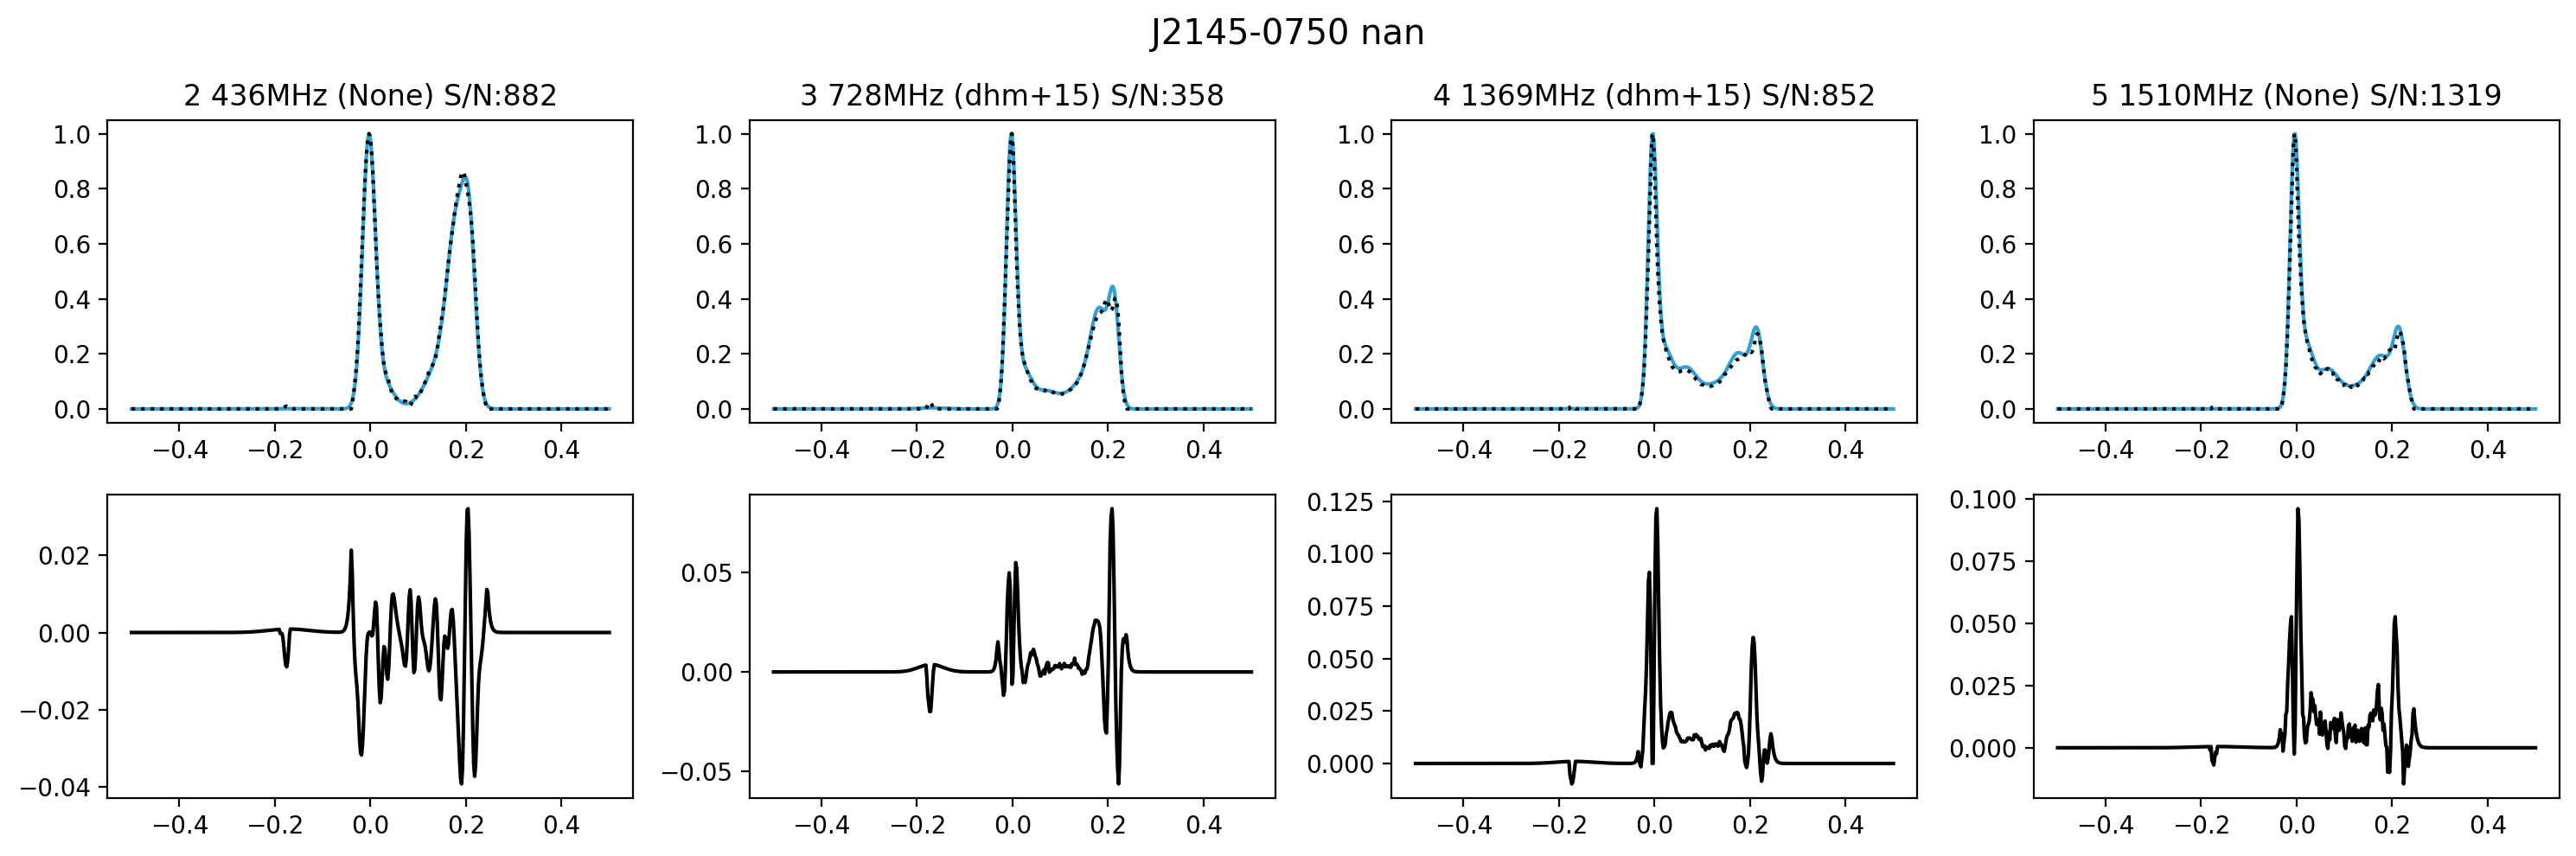

In [6]:
fig, _ax = plt.subplots(2, 4, figsize=(15, 5))

for i, f in enumerate(freqs_to_include):

    if f in pulsar.observations:
        obs = pulsar.observations[f]

        ax = _ax[0, i]
        # ax.plot(obs.phase, model_array(copy.deepcopy(obs)), color=blue_full)
        ax.plot(obs.phase, obs.model, color=blue_full)
        ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)
        ax.set_title(f"{f} {obs.frequency:.0f}MHz ({obs.epn_reference_code}) S/N:{obs.snr:.0f}")

        # ax.plot(obs.phase, obs.stokes_V, color='black', linestyle=':', zorder=1000)
        # ax.plot(obs.phase, obs.stokes_L, color='black', linestyle=':', zorder=1000)

        ax = _ax[1, i]
        ax.plot(obs.phase, obs.model - obs.stokes_I, color='black')
        # ax.annotate(f"{obs.model_agd['best_fit_rchi2'][0][0]:.2f}", [0.1, 0.9], xycoords='axes fraction')

plt.suptitle(f"{pulsar.jname} {pulsar.bname}", fontsize='x-large')
plt.tight_layout()
plt.savefig(f'images/all_freq_bins_stokes_I/{pulsar.jname}.pdf')

In [ ]:
fig, _ax = plt.subplots(2, 4, figsize=(15, 5))

for i, f in enumerate(freqs_to_include):

    if f in pulsar.observations:
        obs = pulsar.observations[f]

        ax = _ax[0, i]
        # ax.plot(obs.phase, model_array(copy.deepcopy(obs)), color=blue_full)
        ax.plot(obs.phase, obs.model, color=blue_full)
        ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)
        ax.set_title(f"{f} {obs.frequency:.0f}MHz ({obs.epn_reference_code}) S/N:{obs.snr:.0f}")

        # ax.plot(obs.phase, obs.stokes_V, color='black', linestyle=':', zorder=1000)
        # ax.plot(obs.phase, obs.stokes_L, color='black', linestyle=':', zorder=1000)

        ax = _ax[1, i]
        ax.plot(obs.phase, obs.model - obs.stokes_I, color='black')
        # ax.annotate(f"{obs.model_agd['best_fit_rchi2'][0][0]:.2f}", [0.1, 0.9], xycoords='axes fraction')

plt.suptitle(f"{pulsar.jname} {pulsar.bname}", fontsize='x-large')
plt.tight_layout()
plt.savefig(f'images/all_freq_bins_stokes_I/{pulsar.jname}.pdf')

In [ ]:
with_interpulse = ['J1705-1906', 'J1825-0935', 'J1857+0943', 'J1932+1059', 'J1939+2134', 'J0534+2200']

# Plot individual pulsars

blue_full = (47/255, 161/255, 214/255, 1)
freqs_to_include = [2,3,4,5]
# population = population_agd

# for pulsar in tqdm(population.as_array()):
for jname in with_interpulse:
    pulsar = population.pulsars[jname]

    fig, _ax = plt.subplots(2, 4, figsize=(15, 5))

    for i, f in enumerate(freqs_to_include):
        
        if f in pulsar.observations:
            obs = pulsar.observations[f]
            
            ax = _ax[0, i]
            # ax.plot(obs.phase, model_array(copy.deepcopy(obs)), color=blue_full)
            ax.plot(obs.phase, obs.model, color=blue_full)
            ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)
            ax.set_title(f"{f} {obs.frequency:.0f}MHz ({obs.epn_reference_code}) S/N:{obs.snr:.0f}")
            
            # ax.plot(obs.phase, obs.stokes_V, color='black', linestyle=':', zorder=1000)
            # ax.plot(obs.phase, obs.stokes_L, color='black', linestyle=':', zorder=1000)
            
            ax = _ax[1, i]
            ax.plot(obs.phase, obs.model - obs.stokes_I, color='black')
            # ax.annotate(f"{obs.model_agd['best_fit_rchi2'][0][0]:.2f}", [0.1, 0.9], xycoords='axes fraction')

    plt.suptitle(f"{pulsar.jname} {pulsar.bname}", fontsize='x-large')
    plt.tight_layout()
    plt.savefig(f'images/all_freq_bins_stokes_I/{pulsar.jname}.pdf')

In [ ]:
t = 1
if t:
    print ('allo')

In [ ]:
population.pulsars[jname].observations[f].model_components